### Sepehr Rezaee - 99242067

In [ ]:
!pip install torch snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.2 MB/s eta 0:00:00


### Import dependencies

In [ ]:
import torch
import snntorch as snn
from snntorch import spikegen
from torch.utils.data import TensorDataset, DataLoader

### Define the network architecture

In [ ]:
class STDPNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(STDPNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=0.1)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=0.1)

        # Initialize mem_0 and mem_1 for both layers
        self.mem_0_1 = torch.zeros(hidden_size)
        self.mem_1_1 = torch.zeros(hidden_size)
        self.mem_0_2 = torch.zeros(output_size)
        self.mem_1_2 = torch.zeros(output_size)

    def forward(self, x):
      x = self.fc1(x)
      x, self.mem_0_1 = self.lif1(x, self.mem_0_1)
      x = self.fc2(x)
      x, self.mem_0_2 = self.lif2(x, self.mem_0_2)
      return x, self.mem_0_1, self.mem_0_2



### Initialize the network

In [ ]:
input_size = 4
hidden_size = 100
output_size = 10
net = STDPNetwork(input_size, hidden_size, output_size)

### Define a loss function

In [ ]:
loss_fn = torch.nn.MSELoss()

### Define an optimizer

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

### Define the STDP rule

In [ ]:
def stdp(s_pre, s_post, w, a_plus, a_minus, tau_plus, tau_minus):
    # Calculate the STDP update
    dw = a_plus * s_pre * torch.exp(-s_post/tau_minus) - a_minus * s_post * torch.exp(-s_pre/tau_plus)
    # Apply the update to the weights
    w += dw
    return w

# Define the reward modulation function
def reward_modulation(r, dw, beta):
    # Modulate the STDP updates based on the reward
    dw *= r * beta
    return dw

### Define the data

In [ ]:
inputs = torch.tensor([
    [0, 0, 0, 0],  # 0
    [0, 0, 0, 1],  # 1
    [0, 0, 1, 0],  # 2
    [0, 0, 1, 1],  # 3
    [0, 1, 0, 0],  # 4
    [0, 1, 0, 1],  # 5
    [0, 1, 1, 0],  # 6
    [0, 1, 1, 1],  # 7
    [1, 0, 0, 0],  # 8
    [1, 0, 0, 1],  # 9
])

targets = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Create a DataLoader

In [ ]:
trainloader = DataLoader(list(zip(inputs, targets)), batch_size=1, shuffle=True)

### Define a training loop

In [ ]:
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Convert the input data to float
        input_data_float = inputs.float()

        # Now use the float data for spike generation
        input_spike_data = snn.spikegen.rate(input_data_float, time_var_input=True)

        # If your input data is not time-varying
        # Assume num_steps is the number of time steps you want
        target_data_float = targets.float()
        label_spike_data = snn.spikegen.rate(target_data_float, num_steps=4)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, s_pre, s_post = net(input_spike_data)


        # Compute loss
        loss = loss_fn(outputs, label_spike_data)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Apply STDP
        for name, param in net.named_parameters():
            if 'weight' in name:
                dw = stdp(s_pre.detach(), s_post.detach(), param.data, a_plus=0.01, a_minus=0.01, tau_plus=20.0, tau_minus=20.0)  # Detach s_pre and s_post here
                param.data = reward_modulation(r=1.0, dw=dw, beta=0.01)

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 10])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
import torch
import snntorch as snn
from snntorch import spikegen
from torch.utils.data import TensorDataset, DataLoader

class STDPNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(STDPNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=0.1)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=0.1)

        # Initialize mem_0 and mem_1 for both layers
        self.mem_0_1 = torch.zeros(hidden_size)
        self.mem_1_1 = torch.zeros(hidden_size)
        self.mem_0_2 = torch.zeros(output_size)
        self.mem_1_2 = torch.zeros(output_size)

    def forward(self, x):
      x = self.fc1(x)
      x, self.mem_0_1 = self.lif1(x, self.mem_0_1)
      x = self.fc2(x)
      x, self.mem_0_2 = self.lif2(x, self.mem_0_2)
      return x, self.mem_0_1, self.mem_0_2

input_size = 4
hidden_size = 100
output_size = 10
net = STDPNetwork(input_size, hidden_size, output_size)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

def stdp(s_pre, s_post, w, a_plus, a_minus, tau_plus, tau_minus):
    # Calculate the STDP update
    dw = a_plus * s_pre * torch.exp(-s_post/tau_minus) - a_minus * s_post * torch.exp(-s_pre/tau_plus)
    # Apply the update to the weights
    w += dw
    return w

# Define the reward modulation function
def reward_modulation(r, dw, beta):
    # Modulate the STDP updates based on the reward
    dw *= r * beta
    return dw

inputs = torch.tensor([
    [0, 0, 0, 0],  # 0
    [0, 0, 0, 1],  # 1
    [0, 0, 1, 0],  # 2
    [0, 0, 1, 1],  # 3
    [0, 1, 0, 0],  # 4
    [0, 1, 0, 1],  # 5
    [0, 1, 1, 0],  # 6
    [0, 1, 1, 1],  # 7
    [1, 0, 0, 0],  # 8
    [1, 0, 0, 1],  # 9
])

targets = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

trainloader = DataLoader(list(zip(inputs, targets)), batch_size=1, shuffle=True)

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Convert the input data to float
        input_data_float = inputs.float()

        # Now use the float data for spike generation
        input_spike_data = snn.spikegen.rate(input_data_float, time_var_input=True)

        # If your input data is not time-varying
        # Assume num_steps is the number of time steps you want
        target_data_float = targets.float()
        label_spike_data = snn.spikegen.rate(target_data_float, num_steps=4)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, s_pre, s_post = net(input_spike_data)


        # Compute loss
        loss = loss_fn(outputs, label_spike_data)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Apply STDP
        for name, param in net.named_parameters():
            if 'weight' in name:
                dw = stdp(s_pre.detach(), s_post.detach(), param.data, a_plus=0.01, a_minus=0.01, tau_plus=20.0, tau_minus=20.0)  # Detach s_pre and s_post here
                param.data = reward_modulation(r=1.0, dw=dw, beta=0.01)

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

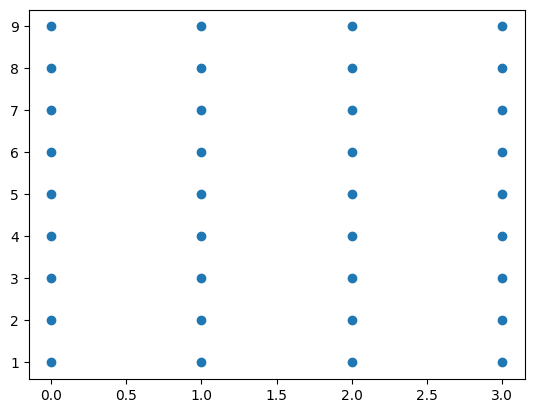

In [ ]:
import snntorch.spikeplot as splt
import snntorch as snn
import torch
import matplotlib.pyplot as plt

# Convert the input data to float
input_data_float = inputs.float()

# Now use the float data for spike generation
spike_data = snn.spikegen.rate(input_data_float, time_var_input=True)

# If your input data is not time-varying
# Assume num_steps is the number of time steps you want
target_data_float = targets.float()
spike_data = snn.spikegen.rate(target_data_float, num_steps=4)




fig, ax = plt.subplots()  # create a new figure with a single Axes
splt.raster(spike_data, ax)  # pass the Axes object to the raster() function
plt.show()  # display the plot


In [ ]:
!pip install brian2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.4 MB/s eta 0:00:00


In [ ]:
from brian2 import *

# Parameters
num_inputs = 4
num_outputs = 10
duration = 100*ms

# Range of weights
weight_min = 0.0
weight_max = 1.0

# STDP learning parameters
taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

# Neuron model
eqs_neurons = '''
dv/dt = (I-v) / (10*ms) : 1 (unless refractory)
I : 1
'''

# Create neurons
G = NeuronGroup(num_outputs, eqs_neurons, threshold='v>1', reset='v = 0', refractory=5*ms, method='exact')

# Initialize weights
weights = np.random.rand(num_inputs, num_outputs)*(weight_max - weight_min) + weight_min

# Create synapses
S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')

S.connect()
S.w = weights.flatten()

# Create input and run simulation
input = np.random.randint(2, size=(num_inputs, int(duration/defaultclock.dt)))
states = StateMonitor(G, 'v', record=True)
spikes = SpikeMonitor(G)

run(duration)

# Plot results
figure(figsize=(12,4))
subplot(121)
plot(spikes.t/ms, spikes.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(states.t/ms, states.v[0], '-k')
xlabel('Time (ms)')
ylabel('v')
tight_layout()
show()


ValueError: ignored